# GUIs y Scripting
*"A user interface is like a joke. If you have to explain it, it's not that good."*
– Martin LeBlanc

En este capítulo, trabajaremos en un proyecto juntos. Escribiremos un scraper simple que busque y guarde imágenes de una página web. Nos centraremos en tres partes:
- [Un script que scrape una URL determinada]()
- [Una aplicación GUI que scrape una URL determinada]()

Una interfaz gráfica de usuario (GUI por sus siglás en inglés) es un tipo de interfaz que permite al usuario interactuar con un dispositivo electrónico a través de iconos gráficos, botones y widgets, a diferencia de las interfaces basadas en texto o de línea de comandos, que requieren que se escriban comandos o texto en el teclado. En pocas palabras, cualquier navegador, cualquier paquete de oficina como LibreOffice y, en general, cualquier cosa que aparezca cuando se hace clic en un icono, es una aplicación GUI.

En este proyecto, la página a la cuál vamos a extraer las imagenes, el título y el precio corresponde a SBS Librería Internacional, específicamente a la sesión Comics, Mangas y Novelas Gráficas (la url es: https://www.sbs.com.pe/comics-manga-y-novelas-graficas.html)

# Primer enfoque: scripting
Ahora, comencemos a escribir el script. Revisaremos el código fuente en tres pasos: importaciones, análisis de argumentos y lógica empresarial.

## Las importaciones
El código comienza con las siguientes líneas:

In [2]:
# pip install beautifulsoup4 requests
import argparse
import base64
import json
from pathlib import Path
import re
from bs4 import BeautifulSoup
import requests
from urllib.parse import urljoin

Al recorrer las importaciones desde el principio, puedes ver que necesitaremos analizar los argumentos, que le proporcionaremos al script (usando `argparse`). Necesitaremos la biblioteca `base64` para guardar las imágenes dentro de un archivo JSON (por lo que también necesitaremos `json`) y necesitaremos abrir archivos para escribir (usando `pathlib`). Finalmente, necesitaremos `BeautifulSoup` para extraer la página web fácilmente y solicitudes para obtener su contenido.

En este punto, lo único que puede resultar un poco confuso es la pareja `base64/json` que estamos usando, así que permítanos dedicarle algunas palabras.

Como vimos en la sesión anterior, JSON es uno de los formatos más populares para el intercambio de datos entre aplicaciones. También se usa ampliamente para otros fines, por ejemplo, para guardar datos en un archivo. En nuestro script, ofreceremos al usuario la posibilidad de guardar imágenes como archivos de imagen o como un solo archivo JSON. Dentro del JSON, colocaremos un diccionario con claves como nombres de imagen y valores como su contenido. El único problema es que guardar imágenes en formato binario es complicado, y aquí es donde la biblioteca base64 viene al rescate.

La biblioteca base64 es bastante útil. Por ejemplo, cada vez que envía un correo electrónico con una imagen adjunta, la imagen se codifica en Base64 antes de que se envíe el correo electrónico. En el extremo del destinatario, las imágenes se decodifican automáticamente a su formato binario original para que el cliente de correo electrónico pueda mostrarlas.

## Análisis de argumentos
Ahora que ya hemos dejado de lado los tecnicismos, veamos la siguiente sección de nuestro script, el análisis de argumentos, que debería estar al final del módulo scrape.py (archivo creado independientemente en la misma carpeta).

Observa la primera línea; es un modismo muy común cuando se trata de scripts. Según la documentación oficial de Python, la cadena `'__main__'` es el nombre del ámbito en el que se ejecuta el código de nivel superior. El atributo `__name__` de un módulo se establece en `__main__` cuando se lee desde la entrada estándar, un script o desde un indicador interactivo.

Por lo tanto, si colocas la lógica de ejecución bajo ese `if`, se ejecutará solo cuando ejecutes el script directamente, ya que su `__name__` será `'__main__'` en ese caso. Por otro lado, si importas objetos desde este módulo, entonces su nombre se establecerá en otra cosa, por lo que la lógica bajo el `if` no se ejecutará.

Lo primero que hacemos es definir nuestro analizador. En la actualidad, existen varias bibliotecas útiles para escribir analizadores de argumentos, como Docopt (https://github.com/docopt/docopt) y Click (https://click.palletsprojects.com/), pero en este caso, preferimos usar el módulo de la biblioteca estándar, `argparse`, que es bastante simple y potente.

Queremos introducir en nuestro script tres datos diferentes: los tipos de imágenes que queremos guardar, el formato en el que queremos guardarlas y la URL de la página que se va a extraer.

Los tipos pueden ser PNG, JPG o ambos (la opción predeterminada), mientras que el formato puede ser imagen o JSON, siendo la imagen la opción predeterminada. La URL es el único argumento obligatorio.

Por lo tanto, agregamos la opción -t, que también permite la versión larga, --type. Las opciones son 'all', 'png' y 'jpg'. Establecemos el valor predeterminado en 'all' y agregamos un mensaje de ayuda.

Realizamos un procedimiento similar para el argumento de formato, permitiendo tanto la sintaxis corta como la larga (-f y --format), y finalmente, agregamos el argumento url, que es el único que se especifica de forma diferente para que no sea tratado como una opción, sino como un argumento posicional.

Para analizar todos los argumentos, todo lo que necesitamos es `parser.parse_args()`.

La última línea es donde activamos la lógica real al llamar a la función `scrape()`, pasando todos los argumentos que acabamos de analizar. Lo bueno de `argparse` es que si llamas al script pasando -h, imprimirá automáticamente un bonito texto de uso, como el siguiente (se debe colocar `python scrape.py -h` en el terminal con el nombre del archivo):

In [1]:
'''
usage: scrape.py [-h] [-t {all,png,jpg}] [-f {img,json}] url 

Scrape a webpage.

positional arguments:
  url                   The URL we want to scrape for images.

options:
  -h, --help            show this help message and exit      
  -t {all,png,jpg}, --type {all,png,jpg}
                        The image type we want to scrape.
  -f {img,json}, --format {img,json}
                        The format images are saved to.
'''

'\nusage: scrape.py [-h] [-t {all,png,jpg}] [-f {img,json}] url \n\nScrape a webpage.\n\npositional arguments:\n  url                   The URL we want to scrape for images.\n\noptions:\n  -h, --help            show this help message and exit      \n  -t {all,png,jpg}, --type {all,png,jpg}\n                        The image type we want to scrape.\n  -f {img,json}, --format {img,json}\n                        The format images are saved to.\n'

## La lógica de negocio
Vamos a sumergirnos en la lógica del código (si parece intimidante, no te preocupes; lo repasaremos juntos).

Dentro del script, esta lógica se encuentra después de las importaciones y antes del análisis (antes de la cláusula `if __name__`):

In [3]:
def scrape(url, format_, type_):
    try:
        page = requests.get(url)
        page.raise_for_status()  # Asegúrate de que no hubo errores al hacer la solicitud
    except requests.RequestException as err:
        print(str(err))
    else:
        soup = BeautifulSoup(page.content, 'html.parser')
        images = fetch_images(soup, url)
        images = filter_images(images, type_)
        save(images, format_)
        save_json_with_titles_prices(images)  # Siempre guardar la información en un archivo JSON


Empecemos con la función `scrape()`. Lo primero que hace es buscar la página en el argumento url dado. Cualquier error que pueda ocurrir al hacer esto, lo atrapamos en `RequestException (err)` y lo imprimimos. `RequestException` es la clase de excepción base para todas las excepciones en la librería de `requests`.

Sin embargo, si las cosas van bien, y tenemos una página de vuelta de la solicitud `GET`, entonces podemos proceder (rama `else`) y alimentar su contenido al analizador `BeautifulSoup`. La librería `BeautifulSoup` nos permite parsear una página web en poco tiempo, sin tener que escribir toda la lógica que se necesitaría para encontrar todas las imágenes de una página. Para obtener las imágenes, usamos la función `fetch_images()` y las filtramos con `filter_images()`. Finalmente, llamamos a `save()` y `save_json_with_titles_prices()` para guardar las imagenes y su información en un archivo json respectivamente.

Dividir el código en diferentes funciones con nombres significativos nos permite leerlo más fácilmente. Aunque no hayas visto la lógica de las funciones `fetch_images()`, `filter_images`(), y `save_json_with_titles_prices()`, no es difícil predecir lo que hacen:



In [4]:
def fetch_images(soup, base_url):
    # Trabaja con rutas relativas y absolutas de src.
    images = []
    for img, title, price in zip(soup.find_all('img', attrs={'class': 'product-image-photo'}),
                          soup.find_all('a', attrs={'class': 'product-item-link'}),
                          soup.find_all('span', attrs={'class': 'price'})):
        src = img.get('src')
        if src:
            img_url = urljoin(base_url, src)  # Construye la URL completa
            name = sanitize_filename(img_url.split('/')[-1])
            product_title = title.get_text(strip=True)
            price = price.get_text(strip=True)
            images.append(dict(name=name, url=img_url, title=product_title, price=price))
    return images

def sanitize_filename(filename):
    # Eliminar los parámetros de la URL después del nombre de archivo
    filename = filename.split('?')[0]
    # Reemplaza caracteres no permitidos en nombres de archivos en Windows
    return re.sub(r'[<>:"/\\|?*]', '_', filename)

La función Fix spacing `fetch_images()` toma un objeto `BeautifulSoup` y una URL base. Todo lo que hace es un bucle a través de todas las imágenes que se encuentran en la página que tienen una clase llamada product-image-photo (además de capturar el título y el precio) y rellenar el nombre y la información url sobre ellos en un diccionario (uno por imagen). Todos los diccionarios se añaden a la lista de imágenes, que se devuelve al final.

Cuando obtenemos el nombre de una imagen, hay algún truco. Dividimos la cadena img_url (por ejemplo, http://localhost:8000/img/my_image_name.png) utilizando '/' como separador, y tomamos el último elemento como nombre de la imagen. Hay una manera más robusta de hacer esto, pero para este ejemplo sería una exageración. Si quieres ver los detalles de cada paso, intenta dividir esta lógica en pasos más pequeños, e imprime el resultado de cada uno de ellos para ayudarte a entender. 

Se puede ver que cada diccionario creado tiene un par clave/valor compuesta por el name, la url, el título y el precio, que podemos usar para buscar, identificar y guardar nuestras imágenes como queramos.

Adicional a ello, hemos usado la función `sanitize_filename` que hemos creado para reemplazar los caracteres no permitidos en nombres de archivos en windows.

A continuación, veremos la estructura de la función `filter_images()`:

In [3]:
def filter_images(images, type_):
    if type_ == 'all':
        return images
    ext_map = {
        'png': ['.png'],
        'jpg': ['.jpg', '.jpeg'],
        'webp': ['.webp'],
    }
    return [
        img for img in images
        if matches_extension(img['name'], ext_map[type_])
    ]

def matches_extension(filename, extension_list):
    extension = Path(filename.lower()).suffix
    return extension in extension_list

En esta función, si `type_` es `all`, no es necesario filtrar, por lo que simplemente devolvemos todas las imágenes. Por otro lado, cuando `type_` no es `all`, obtenemos las extensiones permitidas del diccionario `ext_map`, y lo usamos para filtrar las imágenes en la comprensión de lista que termina el cuerpo de la función. Puedes ver que usando otra función de ayuda, `matches_extension()`, hemos hecho la comprensión de la lista más simple y legible.

Todo lo que hace `matches_extension()` es obtener la extensión del nombre de la imagen y comprobar si está dentro de la lista de las permitidas.

Sigamos revisando el código e inspeccionemos las funciones *save*:

In [5]:
def save_images(images):
    for img in images:
        try:
            response = requests.get(img['url'])
            response.raise_for_status()  # Asegúrate de que la solicitud fue exitosa
            img_data = response.content
            with open(img['name'], 'wb') as f:
                f.write(img_data)
        except requests.RequestException as err:
            print(f"Error al descargar la imagen {img['url']}: {err}")

# Función para guardar las imágenes en un archivo JSON codificadas en base64
def save_json(images):
    data = {}
    for img in images:
        try:
            response = requests.get(img['url'])
            response.raise_for_status()  # Asegúrate de que la solicitud fue exitosa
            img_data = response.content
            b64_img_data = base64.b64encode(img_data)
            str_img_data = b64_img_data.decode('utf-8')
            data[img['name']] = str_img_data
        except requests.RequestException as err:
            print(f"Error al descargar la imagen {img['url']}: {err}")

    with open('images.json', 'w') as ijson:
        ijson.write(json.dumps(data, ensure_ascii=False, indent=4))

# Función para guardar siempre la información en un archivo JSON con títulos y URLs
def save_json_with_titles_prices(images):
    data = []
    for img in images:
        data.append({
            'title': img['title'],
            'image_url': img['url'],
            'image_name': img['name'],
            'price': img['price']
        })

    with open('products.json', 'w', encoding='utf-8') as json_file:
        json.dump(data, json_file, ensure_ascii=False, indent=4)

Puedes ver que, cuando images no está vacío, esto actúa como un despachador. Llamamos a `save_images()` o `save_json()`, dependiendo de la información almacenada en la variable `format_`.

En `save_images()` hacemos un bucle sobre la lista de imágenes y por cada diccionario que encontremos en ella, realizamos una petición GET sobre la URL de la imagen y guardamos su contenido en un fichero, que nombramos como la propia imagen.

La función `save_json()` es muy similar a la anterior. Básicamente rellenamos el diccionario de datos. El nombre de la imagen es la clave, y la representación Base64 de su contenido binario es el valor. Cuando terminamos de rellenar nuestro diccionario, usamos la librería `json` para volcarlo en el archivo `images.json`.

Por último, la función `save_json_with_titles_prices()` guardar siempre la información en un archivo JSON con la siguiente información de los libros: título, url y precio.

Ahora, antes de pasar a la siguiente sección, asegúrate de jugar con este script y entender cómo funciona. Intenta modificar algo, imprimir resultados intermedios, añadir un nuevo argumento o funcionalidad, o desordenar la lógica.

Tener en cuenta que para ejecutar el código debemos colocar en el terminal `python scraping_python.py 'https://www.sbs.com.pe/comics-manga-y-novelas-graficas.html'`.

Ahora vamos a migrarlo a una aplicación GUI, lo que añadirá una capa de complejidad simplemente porque tendremos que construir la interfaz GUI, así que es importante que estés bien familiarizado con la lógica de negocio-te permitirá concentrarte en el resto del código.

# Segundo enfoque: una aplicación GUI
Existen varias bibliotecas para escribir aplicaciones GUI en Python. Algunas de las más famosas son `Tkinter`, `wxPython`, `Kivy` y `PyQt`. Todas ellas ofrecen una amplia gama de herramientas y widgets que puedes utilizar para componer una aplicación GUI.

El que vamos a utilizar es `Tkinter`. `Tkinter` significa interfaz `Tk` y es la interfaz estándar de Python para el conjunto de herramientas GUI `Tk`. Tanto `Tk` como `Tkinter` están disponibles en la mayoría de plataformas Unix, macOS X, así como en sistemas Windows.

Vamos a asegurarnos de que tkinter está instalado correctamente en tu sistema ejecutando este comando en la terminal `python -m tkinter`

Debería abrirse una ventana de diálogo, mostrando una simple interfaz `Tk`. Si usted puede ver eso, podemos comenzar. Sin embargo, si no funciona, por favor busque `tkinter` en la documentación oficial de Python (https://docs.python.org/3.9/library/tkinter.html). Encontrarás varios enlaces a recursos que te ayudarán.

Vamos a hacer una aplicación GUI muy simple que básicamente imita el comportamiento del script que vimos en la primera parte de esta sesión. No vamos a añadir la capacidad de filtrar por tipo de imagen, pero después de haber pasado por este capítulo, usted debe ser capaz de jugar con el código y poner esa característica por sí mismo.

Por lo tanto, esto es lo que estamos apuntando:

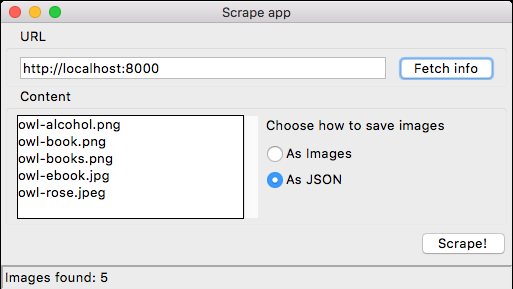

Como se puede ver en la imagen, es una interfaz muy sencilla (en ella se muestra el aspecto que debería tener en un Mac). Hay un marco (es decir, un contenedor) para el campo URL y el botón Fetch info, otro marco para el Listbox (Contenido) que contiene los nombres de las imágenes y los botones de opción para controlar la forma en que las guardamos, y hay un botón Scrape! en la parte inferior derecha. También hay una barra de estado en la parte inferior, que nos muestra alguna información.

Para conseguir este diseño, podríamos simplemente colocar todos los widgets en una ventana raíz, pero eso haría que la lógica del diseño fuera bastante desordenada e innecesariamente complicada. Así que, en lugar de eso, dividiremos el espacio usando marcos y colocaremos los widgets en esos marcos. De esta forma conseguiremos un resultado mucho más bonito. Así que, este es el borrador para el diseño:

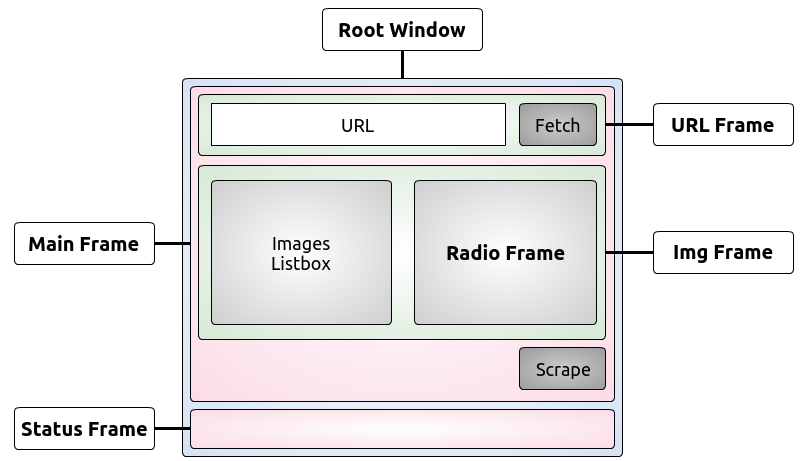

Tenemos una Ventana Raíz, que es la ventana principal de la aplicación. La dividimos en dos filas, la primera en la que colocamos el Marco Principal, y la segunda en la que colocamos el Marco de Estado (que contendrá el texto de la barra de estado). El Marco Principal se divide a su vez en tres filas. En la primera, colocamos el marco URL, que contiene los widgets URL. En la segunda, colocamos el Img Frame, que contendrá el Listbox y el Radio Frame, que albergará una etiqueta y los widgets del botón de radio. Y finalmente, tenemos el tercero, que sólo contendrá el botón Scrape.

Para distribuir los marcos y los widgets, utilizaremos un gestor de diseño llamado grid, que simplemente divide el espacio en filas y columnas, como en una matriz.

Ahora, todo el código que vamos a escribir proviene del módulo `guiscrape.py`, así que no repetiremos su nombre en cada fragmento, para ahorrar espacio. El módulo está dividido lógicamente en tres secciones, no muy diferentes de la versión script: importaciones, lógica de diseño y lógica de negocio. Vamos a analizarlas línea por línea, en tres trozos.

## Las importaciones
Las importaciones son como en la versión script anterior (`scrape.py`), excepto que ya no usamos `argparse`, puesto que en este caso no es necesario, y hemos añadido dos líneas correspondientes a la libreria `tkinter`:

In [7]:
# Nuevas lineas a importar
from tkinter import *
from tkinter import ttk, filedialog, messagebox

# Importaciones del código anterior
import base64
import json
from pathlib import Path
import re
from bs4 import BeautifulSoup
import requests
from urllib.parse import urljoin

La primera línea es una práctica bastante común cuando se utiliza `tkinter`, aunque en general es una mala práctica importar utilizando la sintaxis *. Hacerlo puede dar lugar a colisiones de nombres, que provocan problemas de shadowing (se define como cuando una variable "oculta" otra variable con el mismo nombre) y, si el módulo importado es muy grande, importarlo todo puede ser costoso computacionalmente.

En la segunda línea, importamos `ttk`, `filedialog`, y `messagebox` explícitamente, siguiendo el enfoque convencional usado con esta librería. `ttk` es el nuevo conjunto de widgets estilizados de `Tkinter`. Se comportan básicamente como los antiguos pero son capaces de dibujarse correctamente según el estilo que tenga tu sistema operativo (OS por sus siglás en inglés), lo cual es genial.

El resto de las importaciones (omitidas) son las que necesitamos para llevar a cabo la tarea que a estas alturas ya conoces bien. Ten en cuenta que no hay nada extra que tengamos que instalar con pip en esta segunda parte; si has instalado los requisitos del anterior scrip, ya tienes todo lo que necesitas.

## La lógica del diseño
Vamos a presentar la lógica del diseño trozo a trozo para poder explicártela fácilmente. Verás cómo se ordenan y pegan todas esas piezas de las que hablamos en el borrador de la maqueta. Primero te mostraremos, como en el script anterior, la parte final del módulo `guiscrape.py`. Dejaremos la parte central, la lógica de negocio, para el final:

In [8]:
if __name__ == "__main__":
    _root = Tk()
    _root.title('Scrape app')

Como ya sabes, sólo queremos ejecutar la lógica cuando el módulo se ejecuta directamente, así que esa primera línea no debería sorprenderte.

En las dos últimas líneas, configuramos la ventana principal, que es una instancia de la clase `Tk`. La instanciamos y le damos un título.

Tenga en cuenta que utilizamos la técnica del guión bajo antepuesto para todos los nombres de los objetos `tkinter`, con el fin de evitar posibles colisiones con los nombres en la lógica de negocio. Es posible que no sea la solución más agradable a la vista, pero hace el trabajo.

In [9]:
_mainframe = ttk.Frame(_root, padding='5 5 5 5')
_mainframe.grid(row=0, column=0, sticky=(E, W, N, S))

Aquí, configuramos el Marco Principal. Es una instancia de `ttk.Frame`. Establecemos `_root` como su padre, y le damos algo de `padding`. El relleno es una medida en píxeles de cuánto espacio debe insertarse entre el contenido interior y los bordes para dejar que el diseño respire un poco. Poco o ningún relleno produce un efecto de sardina, donde parece que los widgets están demasiado apretados.

La segunda línea es más interesante. Colocamos este `_mainframe` en la primera fila (0) y primera columna (0) del objeto padre `(_root)`. También decimos que este marco necesita extenderse en cada dirección usando el argumento `sticky` con las cuatro direcciones cardinales. Si te estás preguntando de dónde han salido, es la magia `from tkinter import *` la que nos los ha traído.

In [10]:
_url_frame = ttk.LabelFrame(
_mainframe, text='URL', padding='5 5 5 5')
_url_frame.grid(row=0, column=0, sticky=(E, W))
_url_frame.columnconfigure(0, weight=1)
_url_frame.rowconfigure(0, weight=1)

A continuación, colocamos la **URL Frame**. Esta vez, el objeto padre es `_mainframe`, como recordarás del borrador de la fígura anterior. Este no es un simple `Frame`; en realidad es un `LabelFrame`, lo que significa que podemos establecer el argumento texto y esperar que se dibuje un rectángulo a su alrededor, con el contenido del argumento texto escrito en la parte superior izquierda del mismo. Posicionamos este marco en (0, 0), y decimos que debe expandirse a la izquierda (W) y a la derecha (E). No necesitamos que se expanda en ninguna de las otras dos direcciones. Finalmente, usamos `rowconfigure()` y `columnconfigure()` para asegurarnos de que se comporta correctamente al cambiar de tamaño. Esto es sólo una formalidad en nuestro diseño actual.

In [13]:
def fetch_url():
    pass

_url = StringVar()
_url.set('https://www.sbs.com.pe/comics-manga-y-novelas-graficas.html')
_url_entry = ttk.Entry(
_url_frame, width=40, textvariable=_url)
_url_entry.grid(row=0, column=0, sticky=(E, W, S, N), padx=5)
_fetch_btn = ttk.Button(
_url_frame, text='Fetch info', command=fetch_url)
_fetch_btn.grid(row=0, column=1, sticky=W, padx=5)

Aquí tenemos el código para disponer el cuadro de texto URL y el botón `_fetch`. Un cuadro de texto en el entorno `Tkinter` se llama `Entry`. Lo instanciamos como de costumbre, estableciendo `_url_frame` como su padre y dándole un ancho en píxeles. Además, y esta es la parte más interesante, establecemos que el argumento `textvariable` sea `_url`. `_url` es un `StringVar`, que es un objeto que ahora está conectado a `Entry` y se utilizará para manipular su contenido. Esto significa que no modificaremos el texto de la instancia `_url_entry` directamente, sino accediendo a `_url`. En este caso, llamamos al método `set()` sobre él para establecer el valor inicial a la URL de la página a scrapear.

Posicionamos `_url_entry` en (0, 0), estableciendo las cuatro direcciones cardinales para que se adhiera, y también establecemos un poco de relleno extra en los bordes izquierdo y derecho usando `padx`, que añade relleno en el eje x (horizontal). Por otro lado, pady se encarga de la dirección vertical.

A estas alturas, debería estar claro que cada vez que llamamos al método `.grid()` en un objeto, básicamente le estamos diciendo al gestor de diseño de la rejilla que coloque ese objeto en algún lugar, de acuerdo con las reglas que especificamos como argumentos a la llamada a `grid()`.

Del mismo modo, configuramos y colocamos el botón `_fetch`. El único parámetro interesante es `command=fetch_url`. Esto significa que cuando pulsamos este botón, llamamos a la función `fetch_url()` (en este caso hemos creado una función vacía para que no genere error en esa línea de código). Esta técnica se llama **callback**.

In [14]:
_img_frame = ttk.LabelFrame(
_mainframe, text='Content', padding='9 0 0 0')
_img_frame.grid(row=1, column=0, sticky=(N, S, E, W))

Esto es lo que llamamos **Img Frame** en el borrador de diseño. Se coloca en la segunda fila de su padre `_mainframe`. Contendrá el **Listbox** y el **Radio Frame**:

In [15]:
_images = StringVar()
_img_listbox = Listbox(
_img_frame, listvariable=_images, height=6, width=25)
_img_listbox.grid(row=0, column=0, sticky=(E, W), pady=5)
_scrollbar = ttk.Scrollbar(
_img_frame, orient=VERTICAL, command=_img_listbox.yview)
_scrollbar.grid(row=0, column=1, sticky=(S, N), pady=6)
_img_listbox.configure(yscrollcommand=_scrollbar.set)

Esta es probablemente la parte más interesante de toda la lógica del diseño. Como hicimos con `_url_entry`, necesitamos controlar el contenido de **Listbox** vinculándolo a una variable `_images`. Configuramos **Listbox** para que `_img_frame` sea su padre, y `_images` sea la variable a la que está vinculada. También pasamos algunas dimensiones.

Lo interesante viene de la instancia `_scrollbar`. Pasamos `orient=VERTICAL` para establecer su orientación.

Para ligar su posición al scroll vertical de **Listbox**, cuando la instanciamos, establecemos su comando a `_img_listbox.yview`. Esta es la primera mitad del contrato que estamos creando entre **Listbox** y **Scrollbar**. La otra mitad la proporciona el método `_img_listbox.configure()`, que establece `yscrollcommand=_scrollbar.set`.

Estableciendo este vínculo recíproco, cuando nos desplacemos sobre **Listbox**, **Scrollbar** se desplazará en consecuencia y, viceversa, cuando accionemos **Scrollbar**, **Listbox** se desplazará en consecuencia.

In [16]:
_radio_frame = ttk.Frame(_img_frame)
_radio_frame.grid(row=0, column=2, sticky=(N, S, W, E))

Colocamos el **Radio Frame**, listo para ser poblado. Observa que **Listbox** está ocupando (0, 0) en `_img_frame`, **Scrollbar** ocupa (0, 1), y por tanto `_radio_frame` irá a (0, 2). Vamos a rellenarlo:

In [17]:
_choice_lbl = ttk.Label(
_radio_frame, text="Choose how to save images")
_choice_lbl.grid(row=0, column=0, padx=5, pady=5)
_save_method = StringVar()
_save_method.set('img')
_img_only_radio = ttk.Radiobutton(
_radio_frame, text='As Images', variable=_save_method,
value='img')
_img_only_radio.grid(
row=1, column=0, padx=5, pady=2, sticky=W)
_img_only_radio.configure(state='normal')
_json_radio = ttk.Radiobutton(
_radio_frame, text='As JSON', variable=_save_method,
value='json')
_json_radio.grid(row=2, column=0, padx=5, pady=2, sticky=W)

En primer lugar, colocamos la etiqueta y le damos algo de relleno. Nótese que la etiqueta y los botones de radio son hijos de `_radio_frame`.

Al igual que para los objetos **Entry** y **Listbox**, **Radiobutton** también es manejado por un enlace a una variable externa, que llamamos `_save_method`. Cada instancia de **Radiobutton** establece un argumento de valor, y comprobando el valor en `_save_method`, sabemos qué botón está seleccionado.

In [19]:
def save():
    pass

_scrape_btn = ttk.Button(
_mainframe, text='Scrape!', command=save)
_scrape_btn.grid(row=2, column=0, sticky=E, pady=5)

En la tercera fila de `_mainframe`, colocamos el botón **¡Scrape!** Su comando es guardar, que guarda las imágenes que se enumeran en **Listbox**, después de haber analizado con éxito una página web (creamos una función save vacia para que no generé error).

In [20]:
_status_frame = ttk.Frame(
_root, relief='sunken', padding='2 2 2 2')
_status_frame.grid(row=1, column=0, sticky=(E, W, S))
_status_msg = StringVar()
_status_msg.set('Type a URL to start scraping...')
_status = ttk.Label(
_status_frame, textvariable=_status_msg, anchor=W)
_status.grid(row=0, column=0, sticky=(E, W))

Terminamos la sección de diseño colocando el marco de estado, que es un simple `ttk.Frame`. Para darle un pequeño efecto de barra de estado, establecemos su propiedad `relief` a `'sunken'` y le damos un padding uniforme de dos píxeles. Necesita pegarse a las partes izquierda, derecha e inferior de la ventana `_root`, así que establecemos su atributo `sticky` a (E, W, S).

A continuación le colocamos una etiqueta y, esta vez, la vinculamos a un objeto `StringVar`, ya que tendremos que modificarla cada vez que queramos actualizar el texto de la barra de estado. Ya deberías estar familiarizado con esta técnica.

Finalmente, en la última línea, ejecutamos la aplicación llamando al método `mainloop()` sobre la instancia `Tk`: `_root.mainloop()`.

Recuerda que todas estas instrucciones se encuentran bajo la cláusula `if __name__ == "__main__"`: en el script original.

Como puedes ver, el código para diseñar nuestra aplicación GUI no es difícil. Es cierto que al principio hay que jugar un poco. No todo funcionará perfectamente en el primer intento, pero es fácil encontrar tutoriales útiles en la web. Ahora vamos a la parte interesante, la lógica de negocio.

## La lógica de negocio
Analizaremos la lógica de negocio de la aplicación GUI en tres partes. Está la lógica de obtención, la lógica de guardado y la lógica de alerta.

### Lógica de obtención
Empecemos con el código para obtener la página y las imágenes:

In [3]:
config = {}

def fetch_url():
    url = _url.get()
    config['images'] = []
    _images.set(())  # initialised as an empty tuple
    try:
        page = requests.get(url)
    except requests.RequestException as err:
        sb(str(err))
    else:
        soup = BeautifulSoup(page.content, 'html.parser')
        images = fetch_images(soup, url)
        if images:
            _images.set(tuple(img['name'] for img in images))
            sb('Images found: {}'.format(len(images)))
        else:
            sb('No images found')
        config['images'] = images


def fetch_images(soup, base_url):
    # Trabaja con rutas relativas y absolutas de src.
    images = []
    for img, title, price in zip(soup.find_all('img', attrs={'class': 'product-image-photo'}),
                          soup.find_all('a', attrs={'class': 'product-item-link'}),
                          soup.find_all('span', attrs={'class': 'price'})):
        src = img.get('src')
        if src:
            img_url = urljoin(base_url, src)  # Construye la URL completa
            name = sanitize_filename(img_url.split('/')[-1])
            product_title = title.get_text(strip=True)
            price = price.get_text(strip=True)
            images.append(dict(name=name, url=img_url, title=product_title, price=price))
    return images

def sanitize_filename(filename):
    # Eliminar los parámetros de la URL después del nombre de archivo
    filename = filename.split('?')[0]
    # Reemplaza caracteres no permitidos en nombres de archivos en Windows
    return re.sub(r'[<>:"/\\|?*]', '_', filename)

En primer lugar, hablemos del diccionario de configuración. Necesitamos alguna forma de pasar datos entre la aplicación GUI y la lógica de negocio. Ahora, en lugar de contaminar el espacio de nombres global con muchas variables diferentes, una técnica sencilla es tener un único diccionario que contenga todos los objetos que necesitamos pasar de un lado a otro.

En este sencillo ejemplo, sólo rellenaremos el diccionario de configuración con las imágenes que obtengamos de la página, pero queríamos mostrarte la técnica para que tengas al menos un ejemplo.

Esta técnica procede de nuestra experiencia con JavaScript. Cuando se codifica una página web, a menudo se importan varias bibliotecas diferentes. Si cada una de ellas abarrotara el espacio de nombres global con todo tipo de variables, podría haber problemas para hacer que todo funcionara, debido a los conflictos de nombres y a la sobreescritura de variables.

En nuestro caso, encontramos que el uso de una variable de configuración es una buena solución a este problema.

La función `fetch_url()` es bastante similar a lo que hicimos en el script `scrape.py`. Primero, obtenemos el valor de la url llamando a `_url.get()`. Recuerda que el objeto `_url` es una instancia de `StringVar` que está ligada al objeto `_url_entry`, que es una instancia de **Entry**. El campo de texto que se ve en la GUI es el objeto **Entry**, pero el texto detrás de escena es el valor del objeto `StringVar`.

Llamando a `get()` sobre `_url`, obtenemos el valor del texto que se muestra en `_url_entry`.

El siguiente paso es preparar `config['images']` para que sea una lista vacía, y vaciar la variable `_images`, que está ligada a `_img_listbox`. Esto, por supuesto, tiene el efecto de limpiar todos los elementos de `_img_listbox`.

Después de este paso de preparación, podemos intentar obtener la página, usando la misma lógica `try/ except` que adoptamos en `scrape.py`. La única diferencia es la acción que tomamos si las cosas van mal. Dentro de la aplicación GUI, llamamos a `sb(str(err))`. Veremos el código para la función de ayuda `sb()` en breve. Básicamente, establece el texto en la barra de estado para nosotros. Una vez que sabes que `sb` significa «barra de estado», tiene sentido, ¿verdad? Sin embargo, diríamos que no es un buen nombre. Tuvimos que explicarle su comportamiento, lo que significa que no es autoexplicativo. Dejamos esto como un ejemplo de lo fácil que puede ser escribir código de mala calidad que sólo tiene sentido una vez que nuestra cabeza está envuelta alrededor de él, por lo que es difícil de detectar.

Si podemos obtener la página, entonces creamos la instancia `soup` y obtenemos las imágenes de ella. La lógica de `fetch_images()` es exactamente la misma que la explicada antes, así que no la repetiremos aquí.

Si tenemos imágenes, usando una comprensión rápida de tupla (que en realidad es una expresión generadora alimentada a un constructor de tupla) alimentamos `_images` como `StringVar` y esto tiene el efecto de rellenar nuestro `_img_listbox` con todos los nombres de las imágenes. Finalmente, actualizamos la barra de estado.

Si no hubiera imágenes, actualizaríamos la barra de estado. Al final de la función, independientemente del número de imágenes encontradas, actualizamos `config['images']` para que contenga la lista de imágenes. De esta forma, podremos acceder a las imágenes desde otras funciones inspeccionando `config['images']` sin tener que pasar esa lista.

### Lógica de guardado
La lógica para guardar las imágenes es bastante sencilla. Aquí está:

In [4]:
def save():
    if not config.get('images'):
        alert('No images to save')
        return

    if _save_method.get() == 'img':
        dirname = filedialog.askdirectory(mustexist=True)
        save_images(dirname)
    else:
        filename = filedialog.asksaveasfilename(
            initialfile='images.json',
            filetypes=[('JSON', '.json')])
        save_json(filename)


def save_images(dirname):
    if dirname and config.get('images'):
        for img in config['images']:
            img_data = requests.get(img['url']).content
            filename = Path(dirname).joinpath(img['name'])
            with open(filename, 'wb') as f:
                f.write(img_data)
        alert('Done')

def save_json(filename):
    if filename and config.get('images'):
        data = []
        for img in config['images']:
            data.append({
                'title': img['title'],
                'image_url': img['url'],
                'image_name': img['name'],
                'price': img['price']
            })

    with open(filename, 'w') as ijson:
            ijson.write(json.dumps(data))
    alert('Done')

Cuando el usuario hace clic en el botón **Scrape!**, se llama a la función de guardar mediante el mecanismo de **callback**.

Lo primero que hace esta función es comprobar si realmente hay alguna imagen que guardar. Si no, alerta al usuario de ello, utilizando otra función de ayuda, `alert()`, cuyo código veremos en breve. No se realiza ninguna otra acción si no hay imágenes.

Por otro lado, si la lista `config['images']` no está vacía, `save()` actúa como un despachador, y llama a `save_images()` o a `save_json()`, según el valor que tenga `_save_method`. Recuerda, esta variable está ligada a los botones de radio, por lo tanto esperamos que su valor sea **'img'** o **'json'**.

Este despachador es un poco diferente al script `scrape.py`; hay algunos pasos adicionales que deben tomarse antes de despachar a `save_images()` o `save_json()`.

Si queremos guardar las imágenes en formato imagen, necesitamos pedir al usuario que elija un directorio. Hacemos esto llamando a `filedialog.askdirectory` y asignando el resultado de la llamada a la variable dirname. Esto abre una ventana de diálogo que nos pide que elijamos un directorio. El directorio que elijamos debe existir, tal y como especifica la forma en que llamamos al método. Esto se hace para que no tengamos que escribir código para lidiar con un directorio potencialmente faltante al guardar los archivos.

Así es como debería verse este diálogo en un Mac:

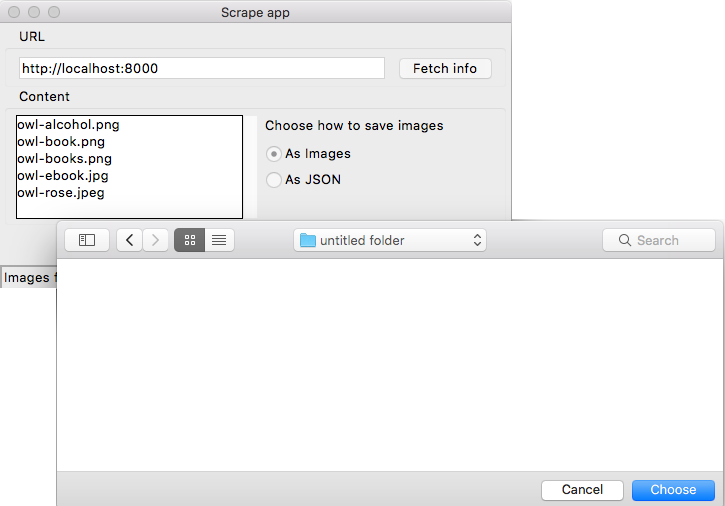

Si cancelamos la operación, dirname se establece en Ninguno.

Antes de terminar de analizar la lógica de `save`, repasemos rápidamente `save_images()`.

Es muy similar a la versión que teníamos en `scrape.py`, así que solo ten en cuenta que, al principio, para estar seguros de que realmente tenemos algo que hacer, verificamos tanto `dirname` como la presencia de al menos una imagen en `config['images']`.

Si ese es el caso, significa que tenemos al menos una imagen para guardar y la ruta para ella, por lo que podemos continuar. La lógica para guardar las imágenes ya se explicó. Lo único que hacemos de manera diferente esta vez es unir el directorio (lo que significa la ruta completa) al nombre de la imagen, por medio del método `Path.joinpath()`.

Al final de `save_images()`, si guardamos al menos una imagen, alertamos al usuario de que hemos terminado.

Ahora volvamos a la otra rama lógica de `save`. Esta rama se ejecuta cuando el usuario selecciona el botón de opción **As JSON** antes de hacer clic en el botón **Scrape!**. En este caso, queremos guardar los datos en un archivo JSON y queremos darle al usuario la posibilidad de elegir también un nombre de archivo. Por lo tanto, iniciamos un cuadro de diálogo diferente: `filedialog.asksaveasfilename`.

Pasamos un nombre de archivo inicial como sugerencia al usuario, que puede elegir cambiarlo si no le gusta. Además, como estamos guardando un archivo JSON, estamos obligando al usuario a usar la extensión correcta al pasar el argumento `filetypes`. Es una lista, con cualquier número de dos tuplas (descripción, extensión), que ejecuta la lógica del cuadro de diálogo.

Así es como debería verse este cuadro de diálogo en macOS:

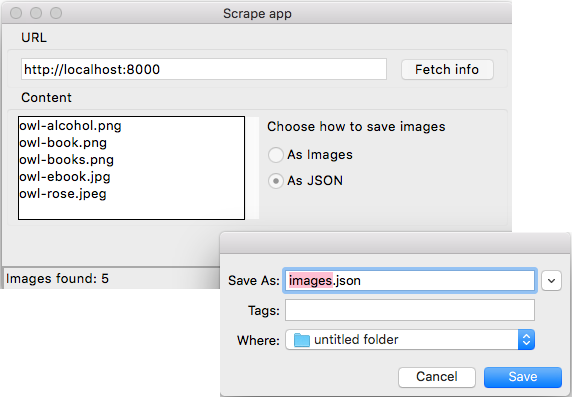

Una vez que hemos elegido un lugar y un nombre de archivo, podemos continuar con la lógica de guardado, que es la misma que en la versión de `scrapy.py`. Creamos un objeto JSON a partir de un diccionario de Python (datos) que hemos rellenado con pares clave/valor formados por el nombre, título y url de la imagen y el contenido codificado en Base64.

En `save_json()` también tenemos una pequeña comprobación al principio que garantiza que no procedamos a menos que tengamos un nombre de archivo y al menos una imagen para guardar. Esto garantiza que si el usuario presiona el botón Cancelar, no sucederá nada.

### Lógica de alerta
Por último, veamos la lógica de las alertas. Es muy sencilla:

In [5]:
def sb(msg):
    _status_msg.set(msg)


def alert(msg):
    messagebox.showinfo(message=msg)

¡Eso es todo! Para cambiar el mensaje de la barra de estado, todo lo que tenemos que hacer es acceder a la variable de cadena `_status_msg`, ya que está vinculada a la etiqueta `_status`.

Por otro lado, si queremos mostrarle al usuario un mensaje más visible, podemos abrir un cuadro de mensaje. Así es como debería verse en una Mac:

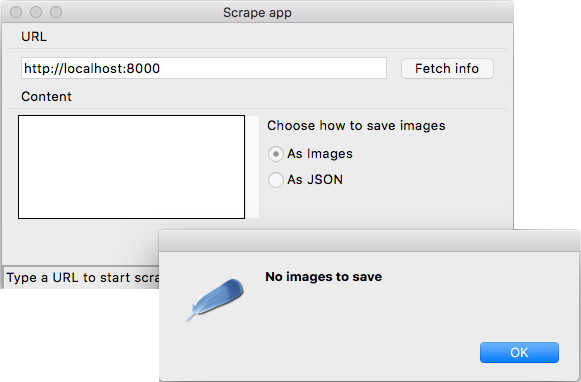

El objeto `messagebox` también se puede utilizar para advertir al usuario (`messagebox.showwarning`) o para señalar un error (`messagebox.showerror`). También se puede utilizar para proporcionar cuadros de diálogo que pregunten al usuario si está seguro de que desea continuar o si realmente desea eliminar un determinado archivo, etc.

Si inspeccionamos `messagebox` simplemente imprimiendo lo que devuelve `dir(messagebox)`, encontramos métodos como `askokcancel()`, `askquestion()`, `askretrycancel()`, `askyesno()` y `askyesnocancel()`, así como un conjunto de constantes para verificar la respuesta del usuario, como **CANCEL**, **NO**, **OK**, **OKCANCEL**, **YES** y **YESNOCANCEL**. Puede utilizar estas constantes comparándolas con la elección del usuario para saber qué acción desea ejecutar cuando se cierra el cuadro de diálogo.

Ahora que hemos explorado el código de esta aplicación, podemos probarla con el siguiente comando en el terminal: `python guiscrape.py`.

### ¿Cómo podemos mejorar la aplicación?
Ahora que ya estas familiarizado con los conceptos básicos del diseño de una aplicación GUI, vamos a sugerir algunas sugerencias sobre cómo mejorar el código.

Podemos empezar con la calidad del código. Comenzamos haciendonos las siguientes preguntas: ¿Cree que este código es lo suficientemente bueno o lo mejoraría? Si es así, ¿cómo? Lo probaríamos y nos aseguraríamos de que sea sólido y se adapte a todos los diversos escenarios que un usuario podría crear al hacer clic en la aplicación. También nos aseguraríamos de que el comportamiento sea el que esperaríamos cuando el sitio web que estamos extrayendo esté inactivo o sea inaccesible por cualquier motivo.

Otra cosa que podríamos mejorar son los nombres que elegimos. Hemos nombrado prudentemente todos los componentes con un guión bajo inicial, tanto para resaltar su naturaleza algo privada como para evitar conflictos de nombres con los objetos subyacentes a los que están vinculados. Pero en retrospectiva, muchos de esos componentes podrían usar un nombre mejor, por lo que realmente depende de usted refactorizar hasta que encuentre la forma que más le convenga.

En lo que respecta a la interfaz de usuario, podrías intentar cambiar el tamaño de la aplicación principal. ¿Ves lo que pasa? Todo el contenido permanece exactamente donde está. Se agrega espacio vacío si expandes, o todo el conjunto de widgets desaparece gradualmente si encoges. Este comportamiento no es aceptable, por lo tanto, una solución rápida podría ser hacer que la ventana raíz sea fija (es decir, que no se pueda cambiar de tamaño).

Otra cosa que podrías hacer para mejorar la aplicación es agregar la misma funcionalidad que teníamos en el script, para guardar solo archivos PNG o JPG. Para hacer esto, podrías colocar un cuadro combinado en algún lugar, con tres valores: Todo, PNG, JPG o algo similar.

El usuario debería poder seleccionar una de esas opciones antes de guardar los archivos.

Mejor aún, podría cambiar la configuración de `Listbox` para que sea posible seleccionar varias imágenes al mismo tiempo y solo se guardarán las seleccionadas. Si logra hacer esto (no es tan difícil como parece), entonces debería considerar presentar el `Listbox` un poco mejor, tal vez proporcionando colores de fondo alternativos para las filas.

Otra cosa buena que podría agregar es un botón que abra un cuadro de diálogo para seleccionar un archivo. El archivo debe ser uno de los archivos JSON que la aplicación puede producir. Una vez seleccionado, podría ejecutar alguna lógica para reconstruir las imágenes a partir de su versión codificada en Base64. La lógica para hacer esto es muy simple, así que aquí hay un ejemplo:

In [7]:
'''
with open('images.json', 'r') as f:
    data = json.loads(f.read())

for (name, b64val) in data.items():
    with open(name, 'wb') as f:
        f.write(base64.b64decode(b64val))
'''


"\nwith open('images.json', 'r') as f:\n    data = json.loads(f.read())\n\nfor (name, b64val) in data.items():\n    with open(name, 'wb') as f:\n        f.write(base64.b64decode(b64val))\n"

Como puede ver, necesitamos abrir `images.json` en modo de lectura y obtener el diccionario de datos. Una vez que lo tengamos, podemos recorrer sus elementos y guardar cada imagen con el contenido decodificado en **Base64**. Dejamos en sus manos vincular esta lógica a un botón en la aplicación.

Otra característica interesante que podría agregar es la capacidad de abrir un panel de vista previa que muestre cualquier imagen que seleccione de **Listbox**, de modo que el usuario pueda echar un vistazo a las imágenes antes de decidir guardarlas.

Otra sugerencia sería agregar un menú. Tal vez incluso un menú simple con Archivo y ? para proporcionar las secciones habituales de Ayuda o Acerca de. Agregar menús no es tan complicado; puede agregar texto, atajos de teclado, imágenes, etc.

En términos de lógica comercial, valdría la pena experimentar con diferentes formas de almacenar los datos que actualmente están almacenados en el diccionario de configuración. Una alternativa sería usar un objeto dedicado. Descubrirá que estar familiarizado con diferentes formas de hacer esto le permite elegir la mejor para la situación en cuestión.

# ¿Hacia dónde vamos desde aquí?
Si está interesado en profundizar en el mundo de las GUI, nos gustaría ofrecerle las siguientes sugerencias.

## El módulo turtle
El módulo turtle es una reimplementación extendida del módulo homónimo de la distribución estándar de Python hasta la versión Python 2.5. Es una forma muy popular de introducir a los niños a la programación.

Se basa en la idea de una tortuga imaginaria que comienza en el centro de un plano cartesiano. Puedes codificar para ordenarle que se mueva hacia adelante y hacia atrás, que rote, etc.; combinando todos los movimientos posibles, se pueden dibujar todo tipo de formas e imágenes intrincadas.

Definitivamente vale la pena probarlo, aunque sea solo para ver algo diferente.

## wxPython, Kivy y PyQt
Después de haber explorado la inmensidad del mundo de `tkinter`, le sugerimos que explore otras bibliotecas GUI: `wxPython` (https://www.wxpython.org/), `PyQt` (https://www.riverbankcomputing.com/software/pyqt/) y `Kivy` (https://kivy.org/). Es posible que una de ellas le resulte más útil o le facilite la codificación de la aplicación que necesita.

Creemos que los programadores pueden materializar sus ideas mucho mejor cuando son conscientes de las herramientas que tienen disponibles. Si su conjunto de herramientas es demasiado limitado, sus ideas pueden parecer imposibles o extremadamente difíciles de transformar en realidad y corren el riesgo de seguir siendo exactamente lo que son, solo ideas.

Por supuesto, el espectro tecnológico actual es enorme, por lo que no es posible saberlo todo; por lo tanto, cuando esté a punto de aprender una nueva tecnología o un nuevo tema, nuestra sugerencia es que aumente su conocimiento explorando primero la amplitud.

Investiga varias cosas y luego profundiza en una o varias que te parezcan más prometedoras. De esta manera, podrás ser productivo con al menos una herramienta y, cuando la herramienta ya no se adapte a tus necesidades, sabrás dónde buscar, gracias a tu exploración previa.

## El principio del mínimo asombro
A la hora de diseñar una interfaz hay que tener en cuenta muchas cosas diferentes. Una de ellas, que nos parece importante, es la ley o principio del mínimo asombro. Establece que si en tu diseño una característica necesaria tiene un alto factor de asombro, puede ser necesario rediseñar tu aplicación.

Por ejemplo, si estás acostumbrado a trabajar con Windows, donde los botones para minimizar, maximizar y cerrar la ventana de una aplicación están en la esquina superior derecha, es bastante difícil trabajar en un Mac, donde esos botones están en la esquina superior izquierda. Te encontrarás yendo constantemente a la esquina superior derecha solo para descubrir una vez más que los botones están en el otro lado.

Si un botón determinado se ha vuelto tan importante en las aplicaciones que ahora los diseñadores lo colocan en una ubicación precisa, no innoves. Simplemente sigue la convención. Los usuarios solo se frustrarán cuando tengan que perder el tiempo buscando un botón que no está donde se supone que debería estar.

## Consideraciones sobre subprocesos
Este tema está fuera del alcance de esta sesión, pero es importante mencionarlo.

Si está codificando una aplicación GUI que necesita realizar una operación de larga duración cuando se hace clic en un botón, verá que su aplicación probablemente se congelará hasta que se haya llevado a cabo la operación. Para evitar esto y mantener la capacidad de respuesta de la aplicación, es posible que deba ejecutar esa operación que consume mucho tiempo en un subproceso diferente (o incluso en un proceso diferente) para que el sistema operativo pueda dedicar un poco de tiempo a la GUI de vez en cuando, para mantenerla sensible.

¡Comprenda bien los conceptos básicos primero y luego diviértase explorándolos!